In [1]:
# !pip install chart_studio

In [2]:
import os 
import random 
from random import sample, choice
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd
from collections import defaultdict

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss,L1Loss

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import KNeighborsClassifier

from pytorch_metric_learning.losses import ContrastiveLoss
import torchinfo 

In [3]:
from src.datasets.data import PAMAP2Reader
# from src.datasets.dataset import PAMAP2Dataset

from src.models.ts_transformer import RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 
from src.utils.losses import *

from src.utils.analysis import action_evaluator

In [4]:
from sklearn.manifold import TSNE
from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [5]:
# import chart_studio
# import chart_studio.plotly as py 
# import chart_studio.tools as tls

# plotly_user = 'nipdep'
# plotly_key = 'BNQUTzoP5YBLtc8uggat'
# chart_studio.tools.set_credentials_file(username=plotly_user, api_key=plotly_key)

In [6]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    "sem-space": 'attr',
    # model training configs
    "include_attribute_loss": True, 
    "n_actions": 18,
    "folding": True,
    "lr": 0.001,
    "ae_lr": 0.0001,
    "imu_lr": 0.0004,
    "ae_alpha": 0.9,
    "imu_alpha": 0.1,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 128, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 128,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---

In [13]:
class Model6a(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(Model6a, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu  # _get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.DenseL1 = nn.Linear(self.ft_size, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)   
        out = self.DenseL1(out1)
        out = self.logist(out)     
        return out, out1

In [14]:
imu_model = Model6a(in_ft=42, d_model=128, num_heads=1, ft_size=64, n_classes=18, max_len=120, dropout=0.1)

In [15]:
torchinfo.summary(imu_model, input_size=(32, 120, 42), col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Model6a                                  [32, 120, 42]             [32, 18]                  --                        --                        --
├─Linear: 1-1                            [32, 120, 42]             [32, 120, 128]            5,504                     --                        176,128
├─RelativeGlobalAttention: 1-2           [32, 120, 128]            [32, 120, 128]            15,360                    --                        --
│    └─Linear: 2-1                       [32, 120, 128]            [32, 120, 128]            16,512                    --                        528,384
│    └─Linear: 2-2                       [32, 120, 128]            [32, 120, 128]            16,512                    --                        528,384
│    └─Linear: 2-3                       [32, 120, 128]            [32, 120, 128]         

In [16]:
class Model6e(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(Model6e, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*self.d_model, self.ft_size)
        self.DenseL1 = nn.Linear(self.ft_size, self.ft_size)
        self.logits = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out1 = self.fc(out)
        out = self.DenseL1(out1)
        out = self.logits(out)
        return out, out1

In [17]:
# test model 
sample_input = torch.randn((32, 120, 42))
model = Model6e(in_ft=42, d_model=128, num_heads=2, ft_size=128, n_classes=2, max_len=120, dropout=0.1)
sample_output = model(sample_input)
sample_output[0].shape, sample_output[1].shape

(torch.Size([32, 2]), torch.Size([32, 128]))

---

In [18]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.concat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32, device='cpu'):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.device = device

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)
              
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

    def forward(self,encoder_hidden):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((self.batch_size,4,self.hidden_size))
            # print(hidden.shape)
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
        else:
            hidden = encoder_hidden.view((self.batch_size,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
        
        dummy_input = torch.rand((self.batch_size,self.seq_len,self.hidden_size), requires_grad=True)
        dummy_input = dummy_input.to(self.device)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True, batch_size=32, device='cpu'):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32, device=device)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [19]:
ae_model = BiLSTMEncDecModel(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=256, num_layers=1,bidirectional=True,batch_size=32)
prep_dir = './tmp/random_input_100_epochs.pt'
ae_model.load_state_dict(torch.load(prep_dir))

<All keys matched successfully>

---

In [20]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
# import PAMAP2 dataset
dt = config['dataset']
if dt == 'PAMAP2':
    dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')

actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\Pose-AE\src\datasets\data.py:65: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [22]:
if dt == 'PAMAP2':
    fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [23]:
skeleton_data = np.load('./data/skeleton_k10_movements.npz')
skeleton_classes, skeleton_mov = skeleton_data['arr_0'], skeleton_data['arr_1']

In [24]:
skeleton_mov.shape

(180, 60, 36)

In [25]:
np.unique(skeleton_classes, return_counts=True)

(array(['Nordic walking', 'ascending stairs', 'car driving',
        'computer work', 'cycling', 'descending stairs', 'folding laundry',
        'house cleaning', 'ironing', 'lying', 'playing soccer',
        'rope jumping', 'running', 'sitting', 'standing',
        'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17'),
 array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10], dtype=int64))

In [26]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [27]:
np.unique(skeleton_classes)

array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17')

In [28]:
from collections import defaultdict

label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(skeleton_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [29]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             9: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             8: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
             5: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
             11: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
             14: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
             15: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
             13: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
             0: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
             6: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
             16: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
             17: [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
             4: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
             1: [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
             2: [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
             12: [150, 151, 152, 153, 154, 155, 156, 157, 158, 15

In [30]:
def get_class_ft(data, model, device, bs=32):
    ns, _, _ = data.shape 
    padded_mat = F.pad(input=data, pad=(0,0,0,0,0,bs-ns), mode='constant', value=0)
    _, vector_out = model(padded_mat.float().to(device)) # batch second mode
    action_feat_mat = vector_out[:ns, :].cpu().detach().numpy()
    return action_feat_mat

---

In [31]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        x_mask = np.array([0]) # self.padding_mask[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences 
        skel_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[skel_idx, ...]
        return x, y, y_feat, x_mask

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat 

In [32]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)
sample_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(d[0].shape)
    break

torch.Size([32, 105, 27])


In [33]:
r = sample_dt.getClassAttrs()
r.shape

torch.Size([14, 60, 36])

In [34]:
pr = F.pad(input=r, pad=(0, 0, 0, 0, 0, 18), mode='constant', value=0)
pr.shape

torch.Size([32, 60, 36])

In [35]:
torch.transpose(r[1, ...], 1, 0).shape

torch.Size([36, 60])

In [36]:
# r_out1, r_out2 = ae_model(torch.transpose(pr, 1, 0).float())
# r_out1.shape, r_out2.shape

---

In [37]:
class SkeletonDataset(Dataset):
    def __init__(self, movements, actions, action_dict, seq_len=60):
        super(SkeletonDataset, self).__init__()
        self.movements = torch.from_numpy(movements[:, :seq_len, ...])
        self.actions = actions
        self.action_dict = deepcopy(dict(action_dict))
        self.actionsIDs = list(self.action_dict.keys())  

    def __getitem__(self, idx):
        x1 = self.movements[idx, ...]
        action = self.actions[idx]
        # partial_idx = random.sample(self.action_dict[action], k=1)[0]
        # x2 = self.movements[partial_idx, ...]
        label = self.actionsIDs.index(action)
        # return np.transpose(x1, (1,0,2)), np.transpose(x2, (1,0,2)), label
        return x1, label

    def __len__(self):
        return self.movements.shape[0]

    def getShape(self):
        return self.movements[0, ...].shape

    def get_actions(self, label):
        return self.movements[self.action_dict[label], ...]


In [38]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             9: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             8: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
             5: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
             11: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
             14: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
             15: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
             13: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
             0: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
             6: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
             16: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
             17: [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
             4: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
             1: [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
             2: [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
             12: [150, 151, 152, 153, 154, 155, 156, 157, 158, 15

In [39]:
sample_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=50)
sample_dl = DataLoader(sample_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
for b in sample_dl:
    bx1, by = b 
    # bx = torch.transpose(bx1, 1, 0)
    bs, seq_len, ft_in = bx1.shape
    print(bx1.shape)
    break 

torch.Size([32, 50, 36])


In [40]:
sample_dt.getShape()

torch.Size([50, 36])

---

In [41]:
class ActionTripletLoss(nn.Module):
    # def __init__(self, action_feats, label_map, pos_thr=0.05, neg_thr=0.95, agg="mean"):
    def __init__(self, action_feats, label_map, distance='cosine', k=10, pos_thr=0.05, neg_thr=0.95, agg="mean", device="cpu"):
        super(ActionTripletLoss, self).__init__()
        self.action_feats = deepcopy(action_feats)
        self.label_map = label_map
        self.get_disMet(distance)
        self.k = k
        self.pos_thr = pos_thr
        self.neg_thr = neg_thr
        self.agg = agg 
        self.device = device 

    def get_disMet(self, distance):
        if distance == 'cosine':
            self.disMet = nn.CosineSimilarity(dim=1, eps=1e-6)
        else:
            self.disMet = nn.PairwiseDistance(p=2)

    def positive_sampling(self, label, k=10):
        total_samples = self.action_feats[label]
        self.n, _ = total_samples.shape 
        sample_idx = sample(range(self.n), k)
        samples = total_samples[sample_idx, :]
        return torch.from_numpy(samples).to(device)

    def negative_sampling(self, label, k=10):
        neg_action = set(self.action_feats.keys())-{label}
        neg_sample_action = sample(neg_action, k)
        sample_point = choice(range(self.n)) # has to change
        neg_samples = np.array([self.action_feats[a][sample_point, :] for a in neg_sample_action])
        neg_samples = torch.from_numpy(neg_samples)
        return neg_samples.to(device)

    def positive_distance(self, pred_vector, pos_vectors, agg='mean'):
        pos_distances = self.disMet(pred_vector, pos_vectors).to(self.device)
        soft_distance = F.relu(torch.sub(torch.abs(pos_distances),Tensor([self.pos_thr]).to(self.device)))
        if agg == "mean":
            return soft_distance.mean()
        else:
            return soft_distance.sum()

    def negative_distance(self, pred_vector, neg_vectors, agg="mean"):
        neg_distances = self.disMet(pred_vector, neg_vectors).to(self.device)
        soft_distance = F.relu(torch.sub(Tensor([self.neg_thr]).to(self.device),torch.abs(neg_distances)))
        if agg == "mean":
            return soft_distance.mean()
        else:
            return soft_distance.sum()

    def forward(self, pred_fts, labels):
        pos_loss, neg_loss = 0, 0
        labels = torch.squeeze(labels).cpu().numpy().tolist()
        # print(labels)
        for i,l in enumerate(labels):
            l = self.label_map[l]
            ft = pred_fts[i, ...]
            pos_vectors = self.positive_sampling(l, self.k)
            neg_vectors = self.negative_sampling(l, self.k)
            pos_loss += self.positive_distance(ft, pos_vectors, agg=self.agg)
            neg_loss += self.negative_distance(ft, neg_vectors, agg=self.agg)

        pos_loss = pos_loss/len(labels)
        neg_loss = neg_loss/len(labels)
        return pos_loss+neg_loss


---

In [42]:
def get_class_avg(data, model, device, bs=32):
    ns, _, _ = data.shape 
    padded_mat = F.pad(input=data, pad=(0,0,0,0,0,bs-ns), mode='constant', value=0)
    _, vector_out = model(padded_mat.float().to(device)) # batch second mode
    action_feat_mat = vector_out[:ns, :].cpu().detach().numpy()
    avg_vector = np.mean(action_feat_mat, axis=0)
    # print(action_feat_mat.shape, avg_vector.shape)
    return avg_vector

In [43]:
def imu_train_step1(model, ae, dataloader, skel_dt, optimizer, loss_module, device, class_names, class_ids, phase='train', l2_reg=False, loss_alpha=0.7, batch_size=32):
    model = model.train()
    ae = ae.eval()

    epoch_loss = 0  # total loss of epoch
    epoch_acc = 0

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, _, padding_masks = batch
            X = X.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
            
            # print(feat_output.shape, targets.shape)
            class_loss = loss_module['class'](class_output, targets.squeeze())
            feat_loss = loss_module['feature'](feat_output, targets)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            pred_class = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            epoch_acc += metrics["accuracy"]
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / len(dataloader)  # average loss per sample for whole epoch
    epoch_acc = epoch_acc / len(dataloader)
    return {'loss': epoch_loss, 'accuracy': epoch_acc}

In [44]:
def ae_train_step1(model, dataloader, optimizer, loss_module, device, batch_size, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    model.to(device)

    const_loss = 0 
    recons_loss = 0
    epoch_loss = 0 

    with tqdm(dataloader, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            xa, labels = batch 
            # post-process 
            # xa = torch.vstack([x1, x2])  # batch first mode
            # device offload 
            xa = xa.float().to(device)
            labels = labels.float()

            # set optimizer grad to zero 
            optimizer.zero_grad()
            # get model prediction 
            with torch.set_grad_enabled(phase=='train'):
                skel_output, ft_output = model(xa)

            # reconstruct the output 
            # f1, f2 = torch.split(ft_output, [batch_size//2, batch_size//2], dim=0)
            # cons_output = torch.stack([f1.squeeze(1), f2.squeeze(1)], dim=1)
            # calc. contrastive loss 
            con_loss = loss_module['contrast'](ft_output, labels)()
            # calc. reconstruction loss 
            l2_loss = loss_module['recons'](xa, skel_output)
            # calc. total loss
            # total_loss = con_loss #
            total_loss = loss_alpha*con_loss + (1-loss_alpha)*l2_loss

            if phase == 'train':
                total_loss.backward()
                optimizer.step()

            metrics = {'contrastive loss ': con_loss.item(), 'reconstruction loss': l2_loss.item()}
            with torch.no_grad():
                    const_loss += con_loss.item()    
                    recons_loss += l2_loss.item()
                    epoch_loss += total_loss.item()
            tepoch.set_postfix(metrics)

    m = len(dataloader)
    epoch_metrics = {'total_loss': epoch_loss/m, 'contrastive_loss': const_loss/m, 'reconstruction_loss':recons_loss/m}
    return epoch_metrics

In [45]:
def plot_umap(X, y, Id2Label):
    umap_2d = UMAP(n_components=2, random_state=43)
    cmp_data = umap_2d.fit_transform(X)

    cmp_df = pd.DataFrame(data=cmp_data, columns=['x', 'y'])
    cmp_df['label'] = y
    cmp_df['action'] = cmp_df['label'].map(Id2Label)

    fig = px.scatter(cmp_df, x='x', y='y', color='action', width=800, height=800, title="UMAP")
    fig.show()

In [46]:
def plot_tnse(X, y, Id2Label):
    tnse = TSNE(n_components=2, init='random', learning_rate='auto', perplexity=15, n_iter=1000)
    cmp_data = tnse.fit_transform(X)

    cmp_df = pd.DataFrame(data=cmp_data, columns=['x', 'y'])
    cmp_df['label'] = y
    cmp_df['action'] = cmp_df['label'].map(Id2Label)

    fig = px.scatter(cmp_df, x='x', y='y', color='action', width=800, height=800, title='t-SNE')
    fig.show()
    return fig

In [47]:
def get_action_vector(ae, skel_dt, device, class_ids, class_names, batch_size=32):
    # generate unseen action_semantic from unseen skeleton seq. 
    label_dict = {c:i for i,c in enumerate(class_ids)}
    all_actions = []
    all_labels = []
    for c in class_ids:
        action_mat = skel_dt.get_actions(c)
        ns, _, _ = action_mat.shape 
        class_labels = [label_dict[c] for _ in range(ns)]
        padded_mat = F.pad(input=action_mat, pad=(0,0,0,0,0,batch_size-ns), mode='constant', value=0)
        _, vector_out = ae(padded_mat.float().to(device)) # batch second mode
        action_feat_mat = vector_out[:ns, :].cpu().detach().numpy() # batch second mode

        all_actions.append(action_feat_mat)
        all_labels.append(class_labels)

    all_actions = np.concatenate(all_actions)
    all_labels = np.concatenate(all_labels)
    Id2Label = {i:l for i,l in enumerate(class_names)}
    return all_actions, all_labels, Id2Label


In [48]:
def eval_step1(model, dataloader, sem_actions, sem_labels, loss_module, device, class_names, class_ids, target_feat_met, phase='seen', l2_reg=False, print_report=True, show_plot=True, loss_alpha=0.7, batch_size=32, neighs=5):
    model = model.train()
    
    label_dict = {c:i for i,c in enumerate(class_ids)}
    inv_label_dict = {i:c for i,c in enumerate(class_ids)}
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': [], 'pred_feat': []}

    all_actions = sem_actions
    all_labels = np.array([label_dict[c] for c in sem_labels])
    # build knn model on know unseen samples 
    knn = KNeighborsClassifier(n_neighbors=neighs)
    knn.fit(all_actions, all_labels)
    # plot t-SNE on unseen vector 
    Id2Label = {i:l for i,l in enumerate(class_names)}
    # plot_tnse(all_actions, all_labels, Id2Label)
    # plot_umap(all_actions, all_labels, Id2Label)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)
            
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)

            # with torch.set_grad_enabled(False):
            #     _, target_feat = ae(target_feat) # batch second mode
            
            if phase == 'seen':
                class_loss = loss_module['class'](class_output, targets.squeeze())
            else:
                class_loss = 0 # 
            feat_loss = loss_module['feature'](feat_output, targets)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            with torch.no_grad():
                epoch_loss += loss.item()  # add total loss of batch
            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            else:
                # print("targets > ", targets)
                # print("feat output", feat_output.shape)
                feat_numpy = feat_output.cpu().detach().numpy()
                pred_action = knn.predict(feat_numpy)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['pred_feat'].append(feat_output.cpu().detach().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    all_pred_actions = np.concatenate(per_batch["pred_feat"])
    # print("predictions > ", all_preds, "ground truth > ", all_targets[:, 0])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict['loss'] = epoch_loss/len(dataloader)
    all_targets = np.array([inv_label_dict[c] for c in all_targets.squeeze()])
    return metrics_dict, all_pred_actions, all_targets

---

Initiate Skeleton dataset ... 


train: 100%|██████████| 5/5 [00:02<00:00,  2.35batch/s, contrastive loss =1.08, reconstruction loss=0.0747]


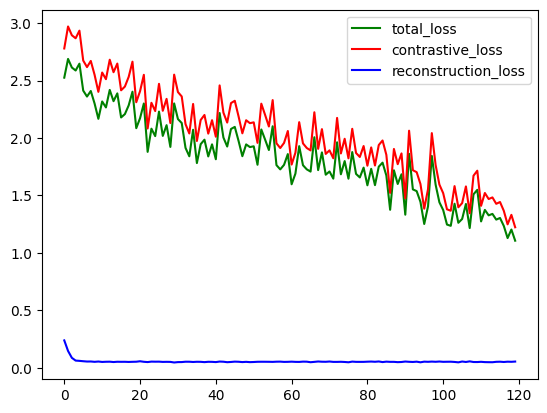

In [49]:
print("Initiate Skeleton dataset ... ")
# prep_dir = './tmp/epoch50_randsample_input_mseloss.pt'
prep_dir = './tmp/random_input_100_epochs.pt'

# build Skeleton dataset 
skel_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=config['seq_len'])
skel_dl = DataLoader(skel_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
skel_n, skel_fts = skel_dt.getShape()

# build AE Model 
# ae_model = BiLSTMEncDecModel(input_size=skel_fts, seq_len=skel_n, hidden_size=config['feat_size'], batch_size=config['batch_size'], ae_type='recursive', device=device)
ae_model = BiLSTMEncDecModel(seq_len=skel_n, input_size=skel_fts, hidden_size=512, linear_filters=[128,256,512], embedding_size=config['feat_size'], num_layers=1, bidirectional=True, batch_size=config['batch_size'], device=device)
# ae_model = BiLSTMEncDecModel(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=256, num_layers=1,bidirectional=True,batch_size=32, device=device)
# ae_model.load_state_dict(torch.load(prep_dir))
ae_model.to(device)

# define AE run parameters 
ae_optim = Adam(ae_model.parameters(), lr=config['ae_lr'])
ae_loss_module = {'contrast': SoftNearestNeighbours, 'recons': nn.MSELoss()}

ae_train_data = []
for epoch in tqdm(range(120), desc='Training Epoch', leave=False):
    # train AE model 
    ae_train_metrics = ae_train_step1(ae_model, skel_dl, ae_optim, ae_loss_module, device, config['batch_size'], phase='train', loss_alpha=config['ae_alpha'])
    ae_train_metrics['epoch'] = epoch
    ae_train_data.append(ae_train_metrics)

ae_train_df = pd.DataFrame().from_records(ae_train_data)

# plot train metrics 
fig, ax = plt.subplots()

ax.plot(ae_train_df['total_loss'], color = 'green', label = 'total_loss')
ax.plot(ae_train_df['contrastive_loss'], color = 'red', label = 'contrastive_loss')
ax.plot(ae_train_df['reconstruction_loss'], color = 'blue', label = 'reconstruction_loss')
ax.legend(loc = 'upper right')
plt.show()

In [50]:
val_actions, val_labels, val_lm = get_action_vector(ae_model, skel_dt, device, class_ids=range(18), class_names=dataReader.idToLabel)
tsne_skel_plot = plot_tnse(val_actions, val_labels, val_lm)
plot_umap(val_actions, val_labels, val_lm)

In [51]:
# py.plot(tsne_skel_plot, filename='TSNE_Skeleton_plot', auto_open=False)

In [52]:
def plot_accVloss(train_data, val_data):
    train_sdf = pd.DataFrame.from_records(train_data)
    val_sdf = pd.DataFrame.from_records(val_data)

    train_sdf['phase'] = 'train'
    val_sdf['phase'] = 'validation'

    all_sdf = pd.concat([train_sdf, val_sdf.loc[:, ['loss', 'accuracy', 'phase']]], axis=0)
    all_sdf = all_sdf.rename_axis('epoch').reset_index()


    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.lineplot(all_sdf, ax=axes[0], x='epoch', y='loss', hue='phase')
    sns.lineplot(all_sdf, ax=axes[1], x='epoch', y='accuracy', hue='phase')

In [53]:
def gen_semantic_space(ft_dict):
    action_ft = np.concatenate(list(ft_dict.values()), axis=0)

    action_label = []
    for i, k in enumerate(ft_dict.keys()):
        action_label.extend([k,]*ft_dict[k].shape[0])

    action_label = np.array(action_label)
    return action_ft, action_label

In [54]:
def over_plot_preds(gt_actions, gt_labels, pred_actions, pred_labels, Id2Label):
    gt_n = gt_actions.shape[0]
    pred_n = pred_actions.shape[0]

    all_actions = np.concatenate([gt_actions, pred_actions])
    all_labels = np.concatenate([gt_labels, pred_labels])
    all_types = ['GT',]*gt_n + ['pred',]*pred_n

    tnse = TSNE(n_components=2, init='random', learning_rate='auto', perplexity=15, n_iter=1000)
    gt_data = tnse.fit_transform(all_actions)

    gt_df = pd.DataFrame(data=gt_data, columns=['x', 'y'])
    gt_df['label'] = all_labels 
    gt_df['action'] = gt_df['label'].map(val_lm)
    gt_df['type'] = all_types

    fig = px.scatter(gt_df, x='x', y='y', color='action', symbol='type', width=800, height=800, title='t-SNE')
    fig.show()

Initiate IMU datasets ...
Initial Models ...
Start Models training ...


seen: 100%|██████████| 130/130 [00:07<00:00, 17.76batch/s, loss=0.644]


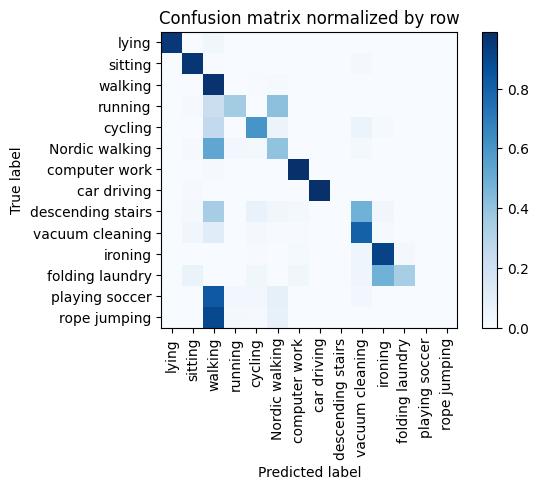

Training Epoch:   4%|▍         | 1/25 [01:19<31:57, 79.90s/it]

Overall accuracy: 0.729



seen: 100%|██████████| 130/130 [00:07<00:00, 16.51batch/s, loss=0.558]


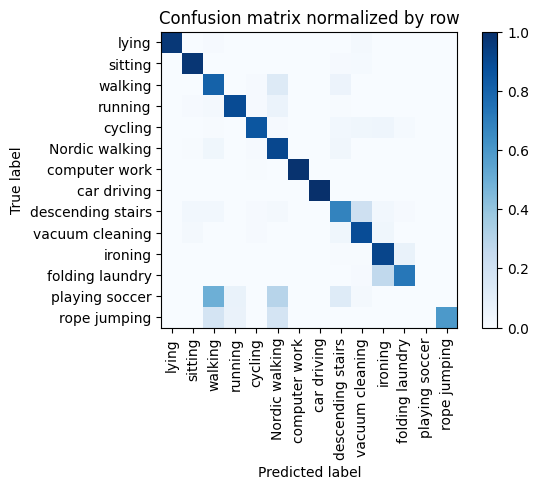

Training Epoch:   8%|▊         | 2/25 [02:47<32:19, 84.31s/it]

Overall accuracy: 0.869



seen: 100%|██████████| 130/130 [00:07<00:00, 17.30batch/s, loss=0.546]


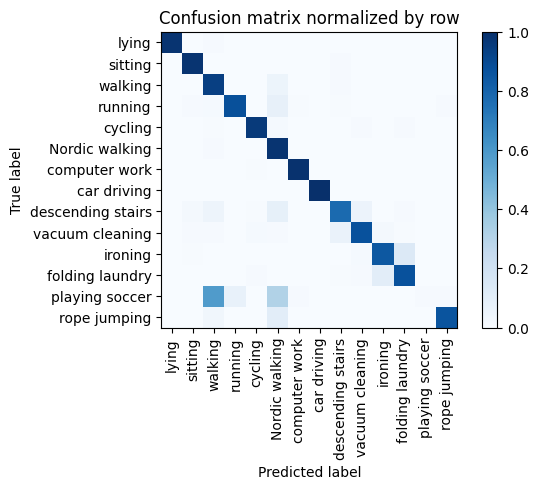

Training Epoch:  12%|█▏        | 3/25 [04:05<29:51, 81.43s/it]

Overall accuracy: 0.906



seen: 100%|██████████| 130/130 [00:11<00:00, 11.12batch/s, loss=0.515]


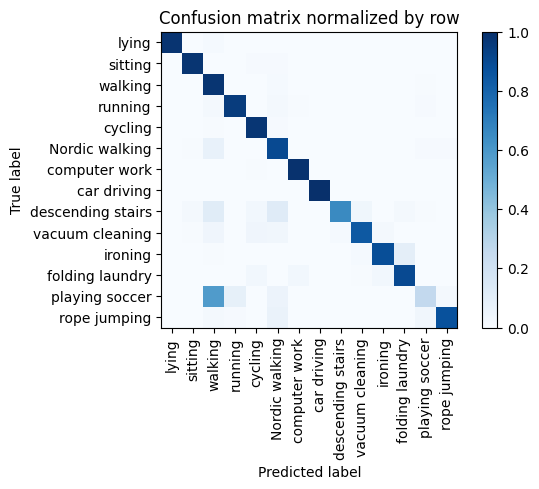

Training Epoch:  16%|█▌        | 4/25 [05:34<29:35, 84.55s/it]

Overall accuracy: 0.912



seen: 100%|██████████| 130/130 [00:07<00:00, 17.89batch/s, loss=0.482]


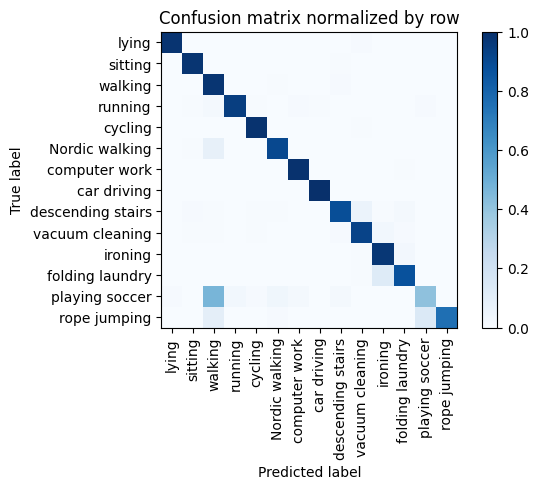

Training Epoch:  20%|██        | 5/25 [06:44<26:28, 79.40s/it]

Overall accuracy: 0.939



seen: 100%|██████████| 130/130 [00:07<00:00, 16.50batch/s, loss=0.439]


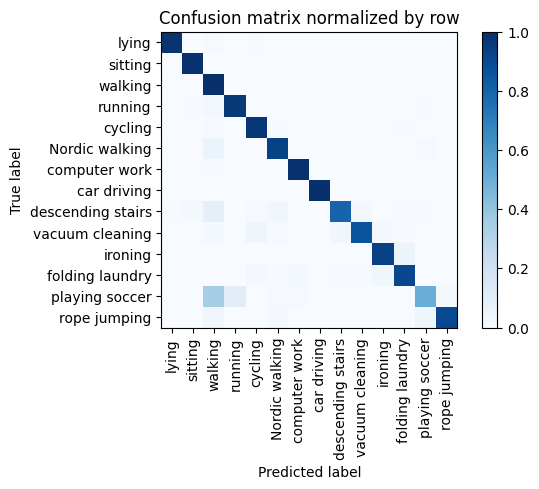

Training Epoch:  24%|██▍       | 6/25 [07:43<22:56, 72.44s/it]

Overall accuracy: 0.938



seen: 100%|██████████| 130/130 [00:07<00:00, 18.24batch/s, loss=0.459]


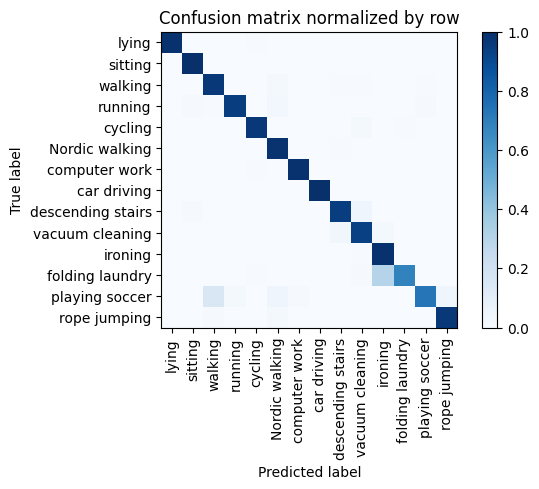

Training Epoch:  28%|██▊       | 7/25 [08:44<20:36, 68.71s/it]

Overall accuracy: 0.956



seen: 100%|██████████| 130/130 [00:07<00:00, 18.17batch/s, loss=0.453]


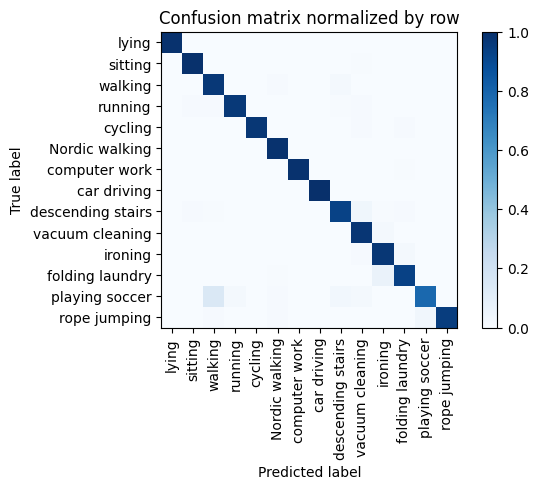

Training Epoch:  32%|███▏      | 8/25 [09:44<18:36, 65.67s/it]

Overall accuracy: 0.970



seen: 100%|██████████| 130/130 [00:07<00:00, 18.00batch/s, loss=0.489]


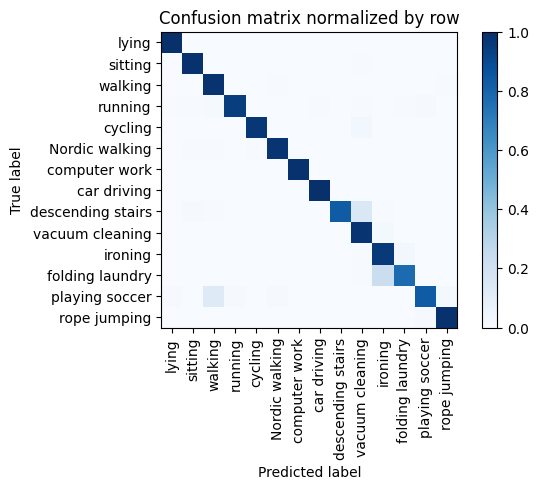

Training Epoch:  36%|███▌      | 9/25 [10:58<18:13, 68.34s/it]

Overall accuracy: 0.961



seen: 100%|██████████| 130/130 [00:07<00:00, 17.24batch/s, loss=0.459]


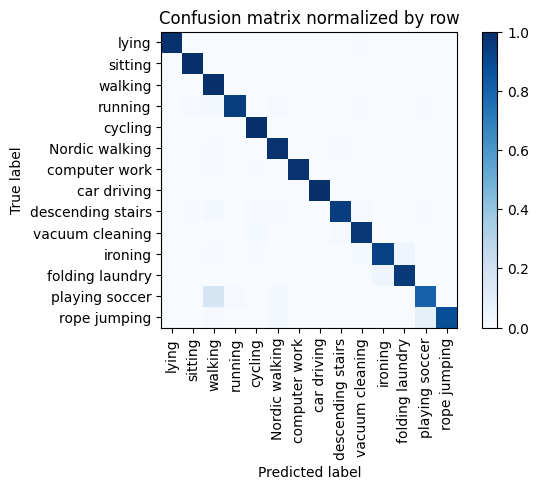

Training Epoch:  40%|████      | 10/25 [12:02<16:47, 67.20s/it]

Overall accuracy: 0.970



seen: 100%|██████████| 130/130 [00:07<00:00, 16.71batch/s, loss=0.442]


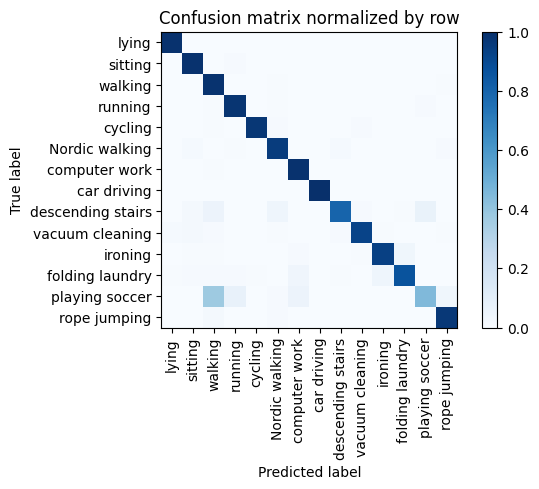

Training Epoch:  44%|████▍     | 11/25 [13:05<15:20, 65.77s/it]

Overall accuracy: 0.945



seen: 100%|██████████| 130/130 [00:07<00:00, 17.35batch/s, loss=0.466]


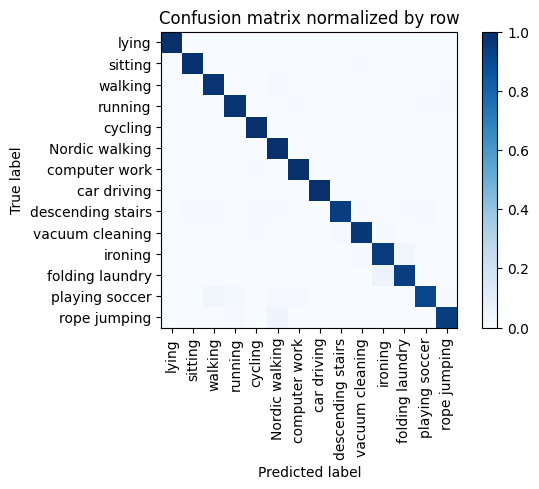

Training Epoch:  48%|████▊     | 12/25 [14:07<14:00, 64.65s/it]

Overall accuracy: 0.978



seen: 100%|██████████| 130/130 [00:07<00:00, 16.82batch/s, loss=0.468]


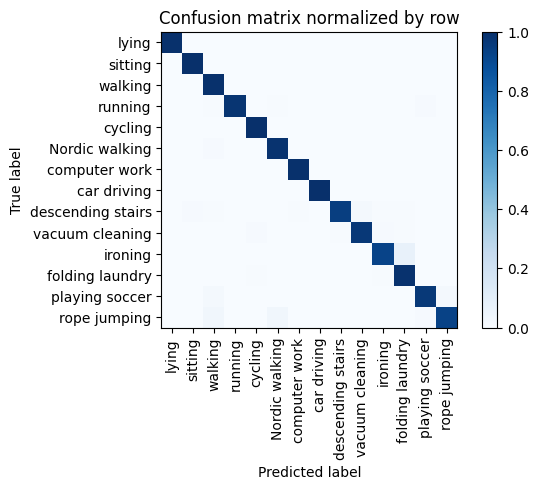

Training Epoch:  52%|█████▏    | 13/25 [15:09<12:45, 63.78s/it]

Overall accuracy: 0.978



seen: 100%|██████████| 130/130 [00:07<00:00, 16.80batch/s, loss=0.446]


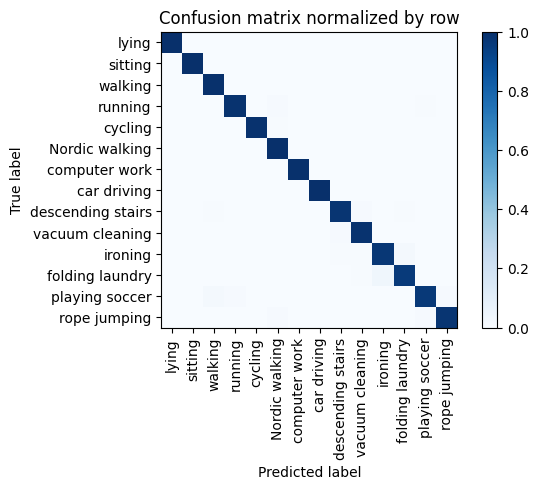

Training Epoch:  56%|█████▌    | 14/25 [16:11<11:36, 63.28s/it]

Overall accuracy: 0.988



seen: 100%|██████████| 130/130 [00:07<00:00, 16.67batch/s, loss=0.443]


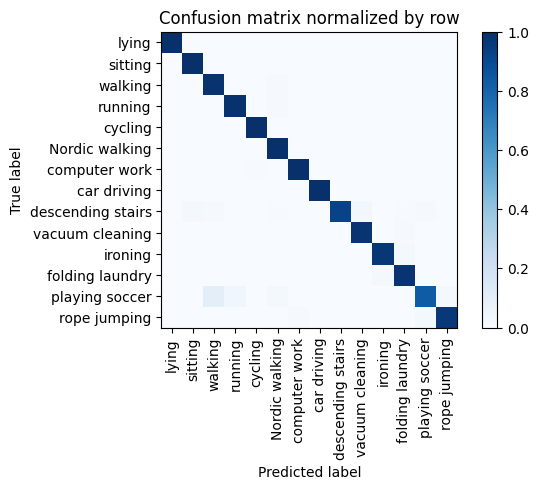

Training Epoch:  60%|██████    | 15/25 [17:14<10:31, 63.13s/it]

Overall accuracy: 0.982



seen: 100%|██████████| 130/130 [00:07<00:00, 17.01batch/s, loss=0.404]


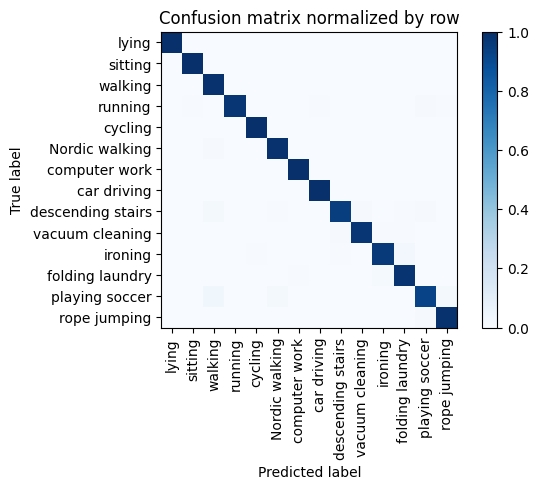

Training Epoch:  64%|██████▍   | 16/25 [18:16<09:25, 62.78s/it]

Overall accuracy: 0.984



seen: 100%|██████████| 130/130 [00:07<00:00, 18.11batch/s, loss=0.445]


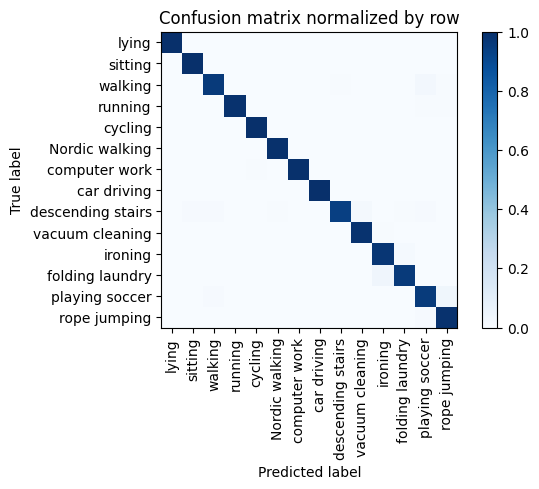

Training Epoch:  68%|██████▊   | 17/25 [19:16<08:15, 62.00s/it]

Overall accuracy: 0.983



seen: 100%|██████████| 130/130 [00:07<00:00, 18.28batch/s, loss=0.432]


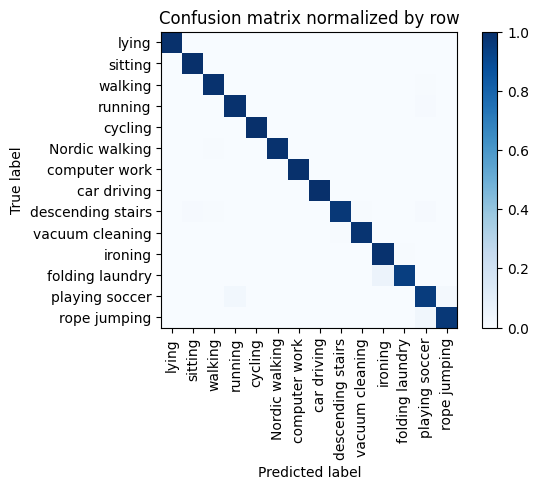

Training Epoch:  72%|███████▏  | 18/25 [20:13<07:04, 60.62s/it]

Overall accuracy: 0.987



seen: 100%|██████████| 130/130 [00:07<00:00, 16.45batch/s, loss=0.431]


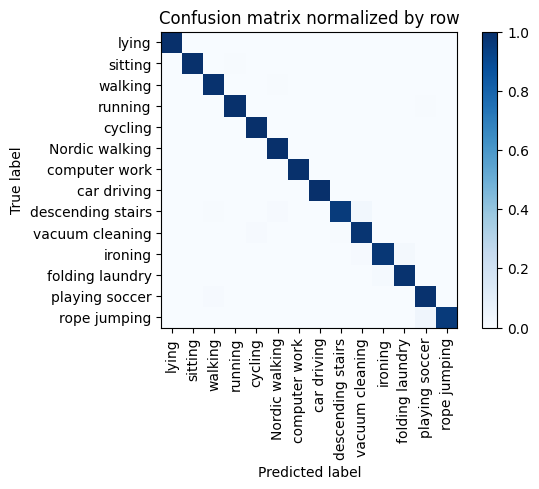

Training Epoch:  76%|███████▌  | 19/25 [21:12<05:59, 59.97s/it]

Overall accuracy: 0.988



seen: 100%|██████████| 130/130 [00:07<00:00, 17.91batch/s, loss=0.421]


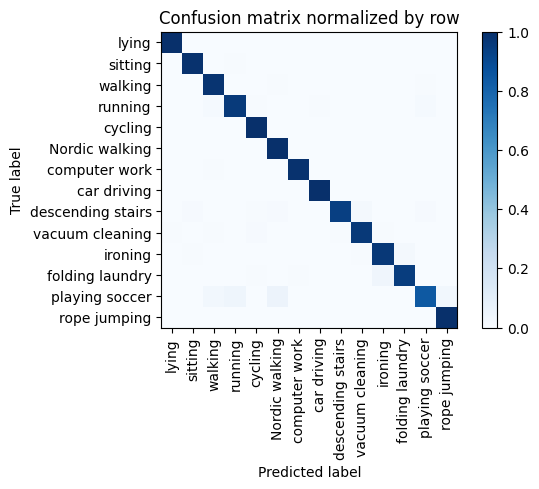

Training Epoch:  80%|████████  | 20/25 [22:10<04:56, 59.37s/it]

Overall accuracy: 0.977



seen: 100%|██████████| 130/130 [00:07<00:00, 17.74batch/s, loss=0.458]


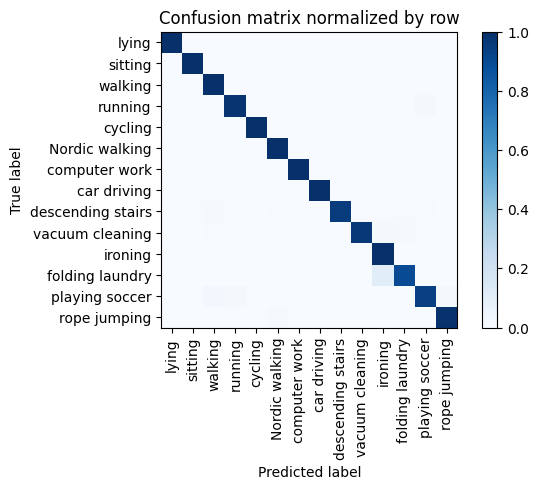

Training Epoch:  84%|████████▍ | 21/25 [23:08<03:55, 58.93s/it]

Overall accuracy: 0.985



seen: 100%|██████████| 130/130 [00:07<00:00, 18.47batch/s, loss=0.438]


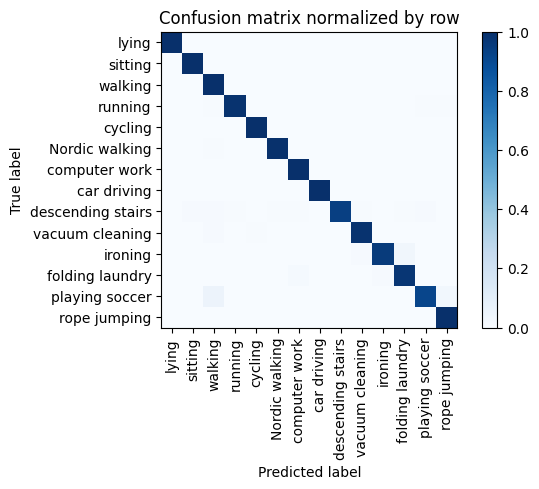

Training Epoch:  88%|████████▊ | 22/25 [24:05<02:55, 58.43s/it]

Overall accuracy: 0.985



seen: 100%|██████████| 130/130 [00:07<00:00, 17.70batch/s, loss=0.448]


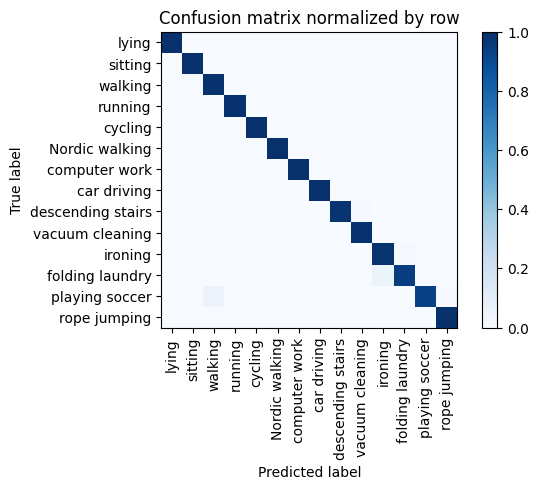

Training Epoch:  92%|█████████▏| 23/25 [25:03<01:56, 58.27s/it]

Overall accuracy: 0.989



seen: 100%|██████████| 130/130 [00:07<00:00, 18.18batch/s, loss=0.395]


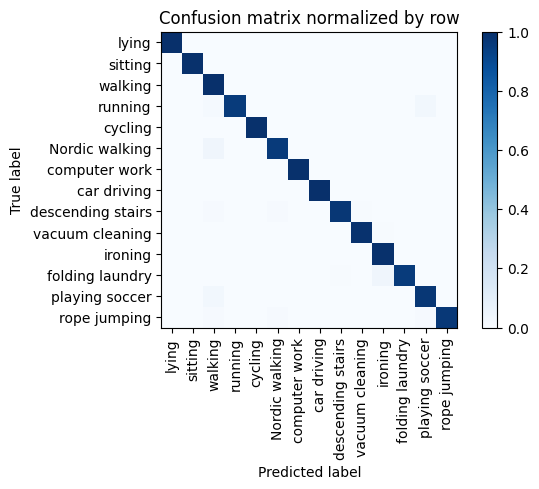

Training Epoch:  96%|█████████▌| 24/25 [26:01<00:58, 58.13s/it]

Overall accuracy: 0.986



seen: 100%|██████████| 130/130 [00:07<00:00, 18.09batch/s, loss=0.477]


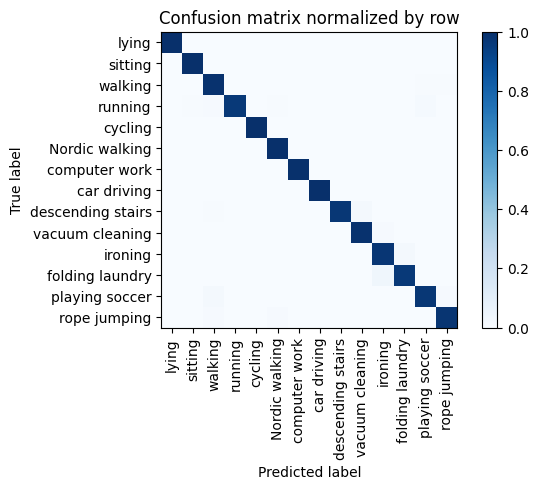

Overall accuracy: 0.988



unseen: 100%|██████████| 175/175 [00:11<00:00, 15.57batch/s, loss=0.215]


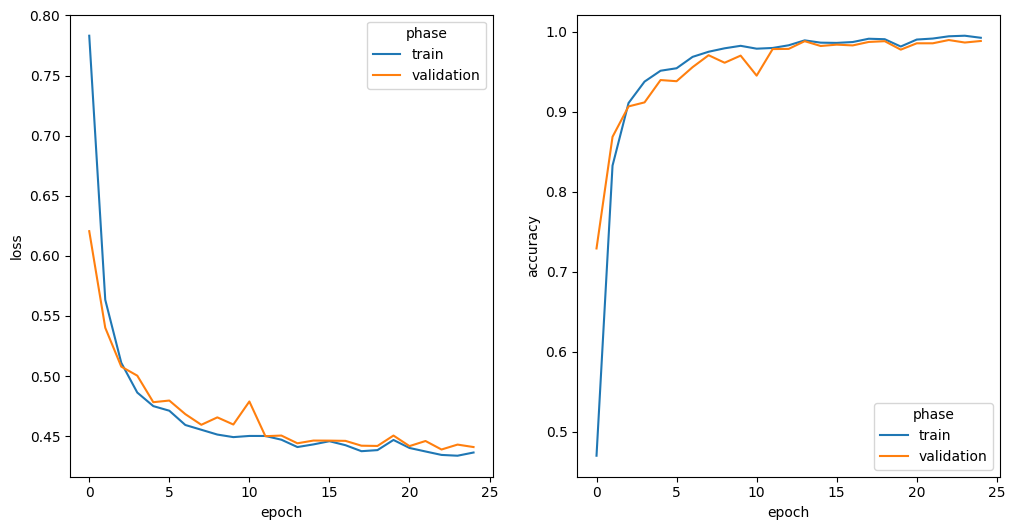

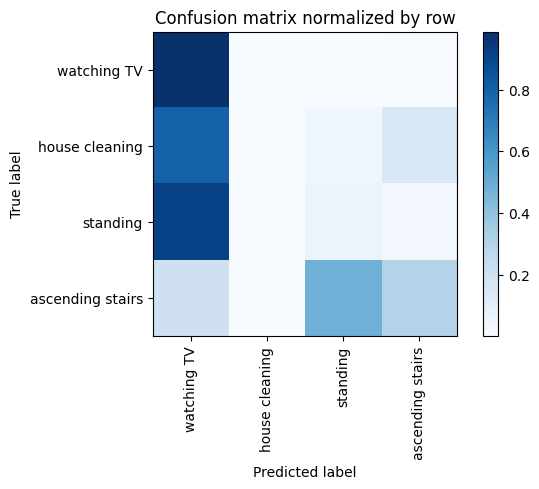

Overall accuracy: 0.223

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.138      0.053      0.077      0.331       1851|	 watching TV: 0.916,	ascending stairs: 0.025,	
  house cleaning       0.200      0.002      0.004      0.329       1840|	 watching TV: 0.799,	ascending stairs: 0.155,	standing: 0.044,	
ascending stairs       0.494      0.304      0.377      0.193       1081|	 standing: 0.487,	watching TV: 0.206,	
     watching TV       0.194      0.987      0.325      0.148        828|	 ascending stairs: 0.006,	standing: 0.005,	

----------------------------------------------------------------------------------------------------
     avg / total       0.235      0.223      0.147        1.0       5600|	      

{'accuracy': 0.22285714285714286, 'precision': 0.25662733799879117, 'recall': 0.33654526734471774, 'f1': 0.19554162891120497, 'loss': 0.20386555543967655}


In [55]:
# print(f'Unseen Classes : {fold_classes[i]}')
# separate seen/unseen and train/eval 
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20, smoothing=True, normalize=False)
all_classes = dataReader.idToLabel
seen_classes = data_dict['seen_classes']
unseen_classes = data_dict['unseen_classes']

train_n, seq_len, in_ft = data_dict['train']['X'].shape

print("Initiate IMU datasets ...")
# build IMU datasets
train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
# build seen eval_dt 
eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
# build unseen test_dt
test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)

print("Initial Models ...")
# build IMU Encoder Model 
imu_model = Model6e(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=config['semantic_size'], max_len=seq_len, n_classes=len(seen_classes))
imu_model.to(device)

# define IMU-Enc run parameters 
seen_action_ft_dict = {a: get_class_ft(torch.from_numpy(skeleton_mov[i, ...]), ae_model, device) for a,i in action_dict.items() if a in seen_classes}
seen_label_map = {i:l for i,l in enumerate(seen_classes)}
trpLoss = ActionTripletLoss(seen_action_ft_dict, seen_label_map, distance='l2', k=10, neg_thr=0.90,pos_thr=0.05, agg="mean", device=device)

# generate unseen semantic space 
unseen_action_ft_dict = {a: get_class_ft(torch.from_numpy(skeleton_mov[i, ...]), ae_model, device) for a,i in action_dict.items() if a in unseen_classes}
seen_label_map = {i:l for i,l in enumerate(unseen_classes)}

seen_action_ft, seen_action_label = gen_semantic_space(seen_action_ft_dict)
unseen_action_ft, unseen_action_label = gen_semantic_space(unseen_action_ft_dict)

imu_optim = Adam(imu_model.parameters(), lr=config['imu_lr'])
imu_loss_module = {'class': nn.CrossEntropyLoss(), 'feature': trpLoss}
best_acc = 0.0

print("Start Models training ...")
fold_train_data = []
fold_val_data = []
# train 2 models E2E
for epoch in tqdm(range(25), desc='Training Epoch', leave=False):
    # train IMU-Enc model
    train_metrics = imu_train_step1(imu_model, ae_model, train_dl, skel_dt, imu_optim, imu_loss_module, device, class_names=[all_classes[i] for i in seen_classes], class_ids=seen_classes, phase='train', loss_alpha=config['imu_alpha'], batch_size=32)
    fold_train_data.append(train_metrics)
    eval_metrics, _, _ = eval_step1(imu_model, eval_dl, seen_action_ft, seen_action_label, imu_loss_module, device=device, class_names=[all_classes[i] for i in seen_classes], class_ids=seen_classes,  target_feat_met=eval_dt.getClassAttrs(), phase='seen', print_report=False, loss_alpha=config['imu_alpha'], batch_size=config['batch_size'], show_plot=True)
    fold_val_data.append(eval_metrics)
    # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
    # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
    if eval_metrics['accuracy'] > best_acc:
        imu_best_model = deepcopy(imu_model.state_dict())


plot_accVloss(fold_train_data, fold_val_data)
# replace by best model 
imu_model.load_state_dict(imu_best_model)

# run evaluation on unseen classes
test_metrics, unseen_pred_actions, unseen_labels = eval_step1(imu_model, test_dl, unseen_action_ft, unseen_action_label, imu_loss_module, device=device, class_names=[all_classes[i] for i in unseen_classes], class_ids=unseen_classes,  target_feat_met=test_dt.getClassAttrs(), phase='unseen', loss_alpha=0.8, batch_size=config['batch_size'])
print(test_metrics)
print("="*40)

In [56]:
over_plot_preds(val_actions, val_labels, unseen_pred_actions[:30, :], unseen_labels[:30], val_lm)

unseen: 100%|██████████| 175/175 [00:11<00:00, 15.85batch/s, loss=0.193]


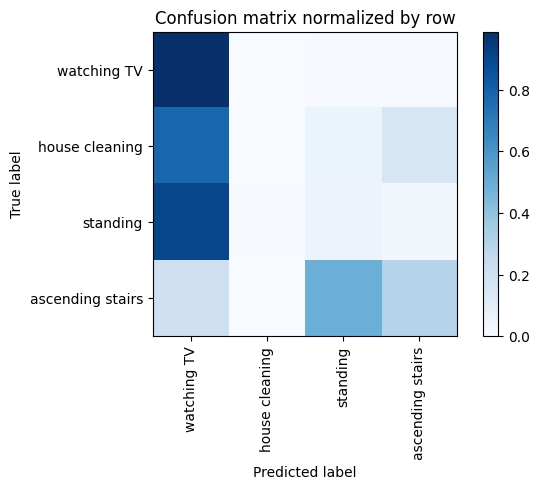

Overall accuracy: 0.223

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.145      0.058      0.083      0.331       1853|	 watching TV: 0.903,	ascending stairs: 0.035,	
  house cleaning       0.250      0.002      0.003      0.328       1839|	 watching TV: 0.783,	ascending stairs: 0.162,	standing: 0.053,	
ascending stairs       0.466      0.297      0.363      0.193       1079|	 standing: 0.491,	watching TV: 0.211,	
     watching TV       0.197      0.988      0.328      0.148        829|	 ascending stairs: 0.007,	standing: 0.005,	

----------------------------------------------------------------------------------------------------
     avg / total       0.249      0.223      0.147        1.0       5600|	      



In [57]:
test_metrics, _, _ = eval_step1(imu_model, test_dl, unseen_action_ft, unseen_action_label, imu_loss_module, device=device, class_names=[all_classes[i] for i in unseen_classes], class_ids=unseen_classes,  target_feat_met=test_dt.getClassAttrs(), phase='unseen', loss_alpha=0.8, batch_size=config['batch_size'], neighs=10)
